**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! You only need to add the final conclusion and the project will be accepted. Let me know if you have questions!

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
# import packages

import math

import numpy as np
import pandas as pd
import re

import spacy
import torch
import transformers
from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

import sklearn.metrics as metrics

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

In [3]:
tqdm.pandas()

In [4]:
sns.set_style("darkgrid")
random_state = 42

## Load Data

In [5]:
try:
    df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except Exception:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [9]:
df_reviews.duplicated().sum()

0

In [10]:
df_reviews.primary_title.nunique()

6555

In [11]:
df_reviews.tconst.nunique()

6648

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected
    
</div>

## EDA

Let's check the number of movies and reviews over years.

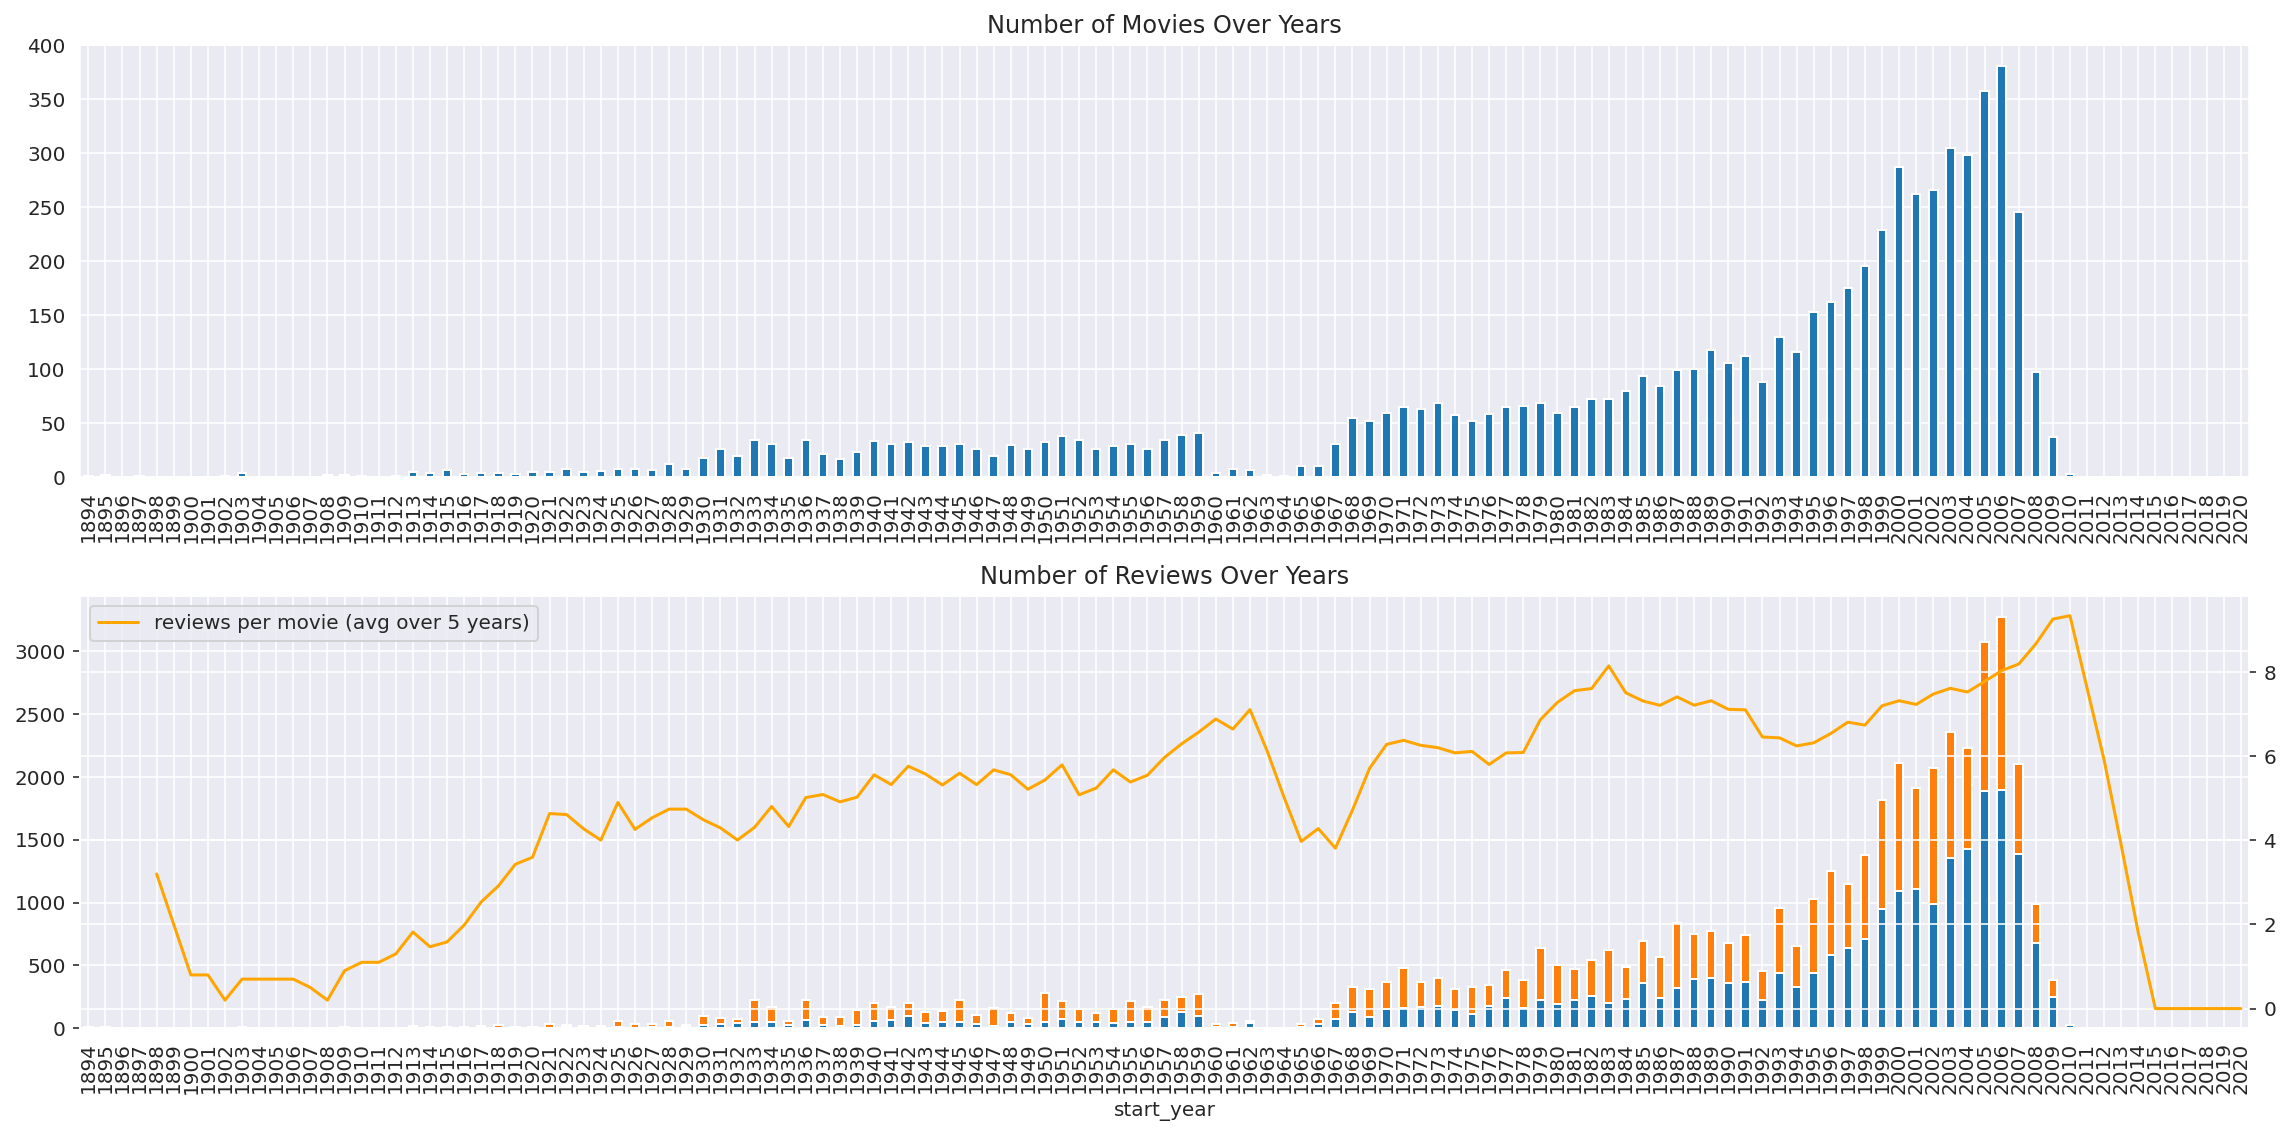

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

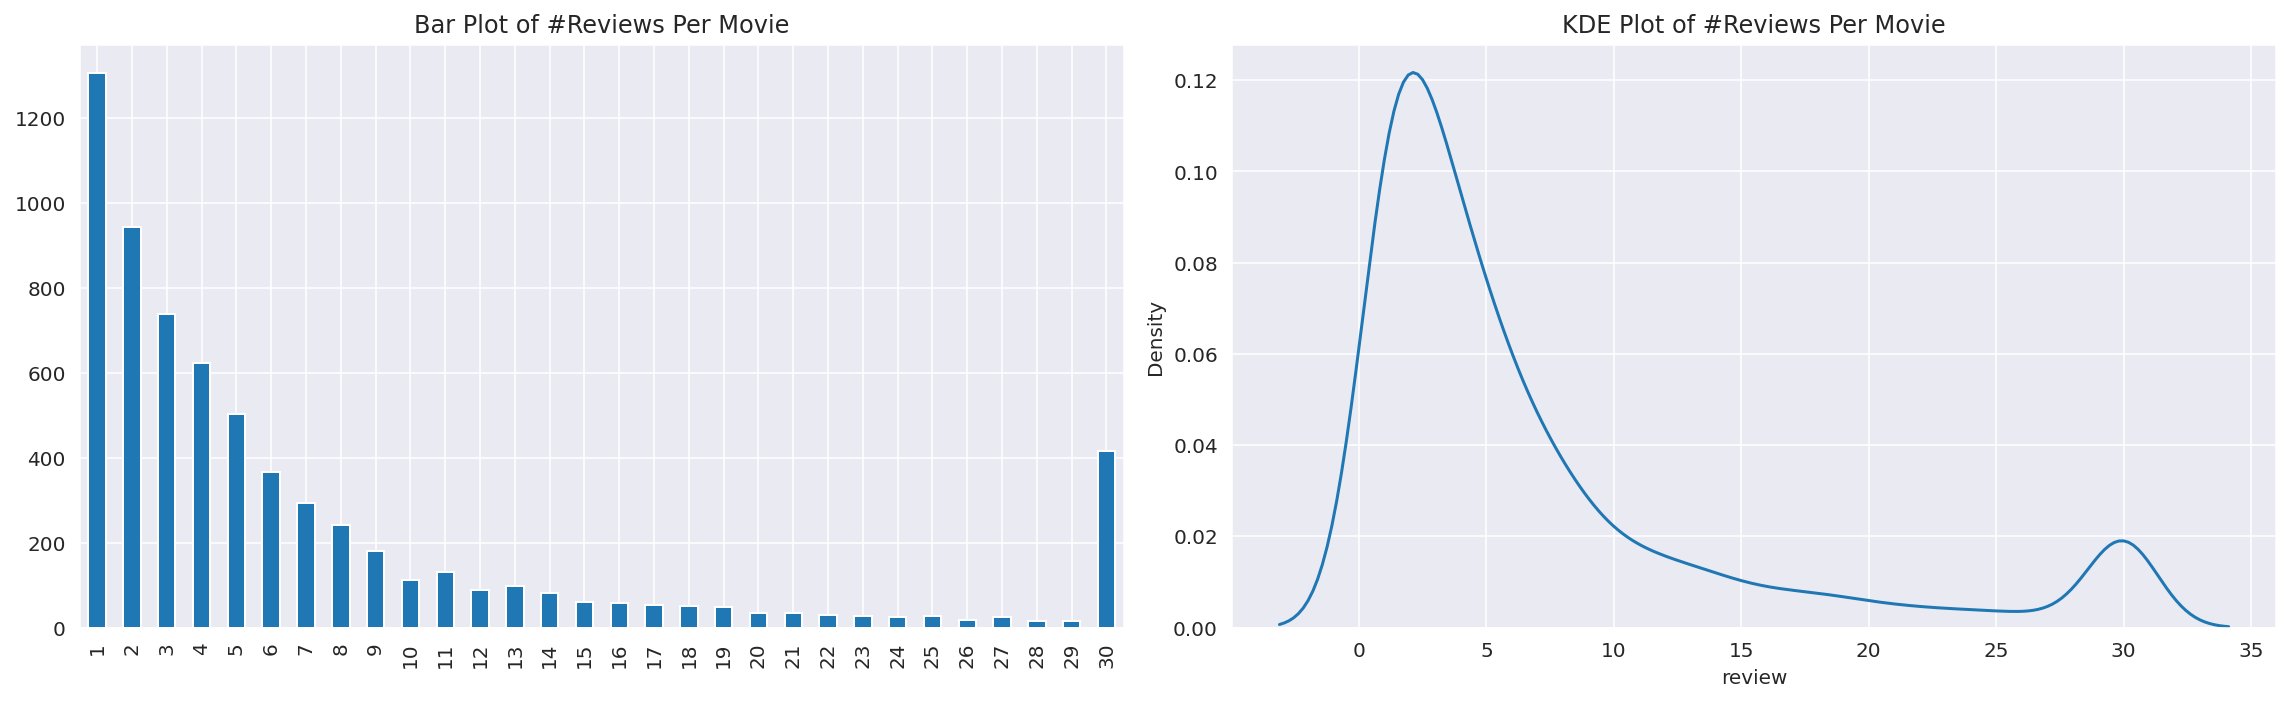

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

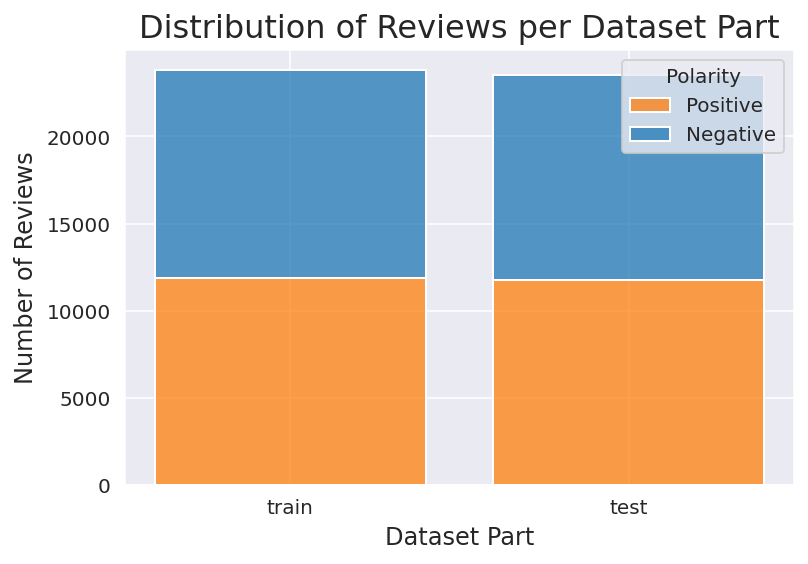

In [15]:
g = sns.histplot(data=df_reviews, x='ds_part', hue='pos', multiple='stack', shrink=.8)
plt.xlabel('Dataset Part', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Polarity', loc='upper right', labels=['Positive', 'Negative'])
plt.title('Distribution of Reviews per Dataset Part', fontsize=16)

plt.show()

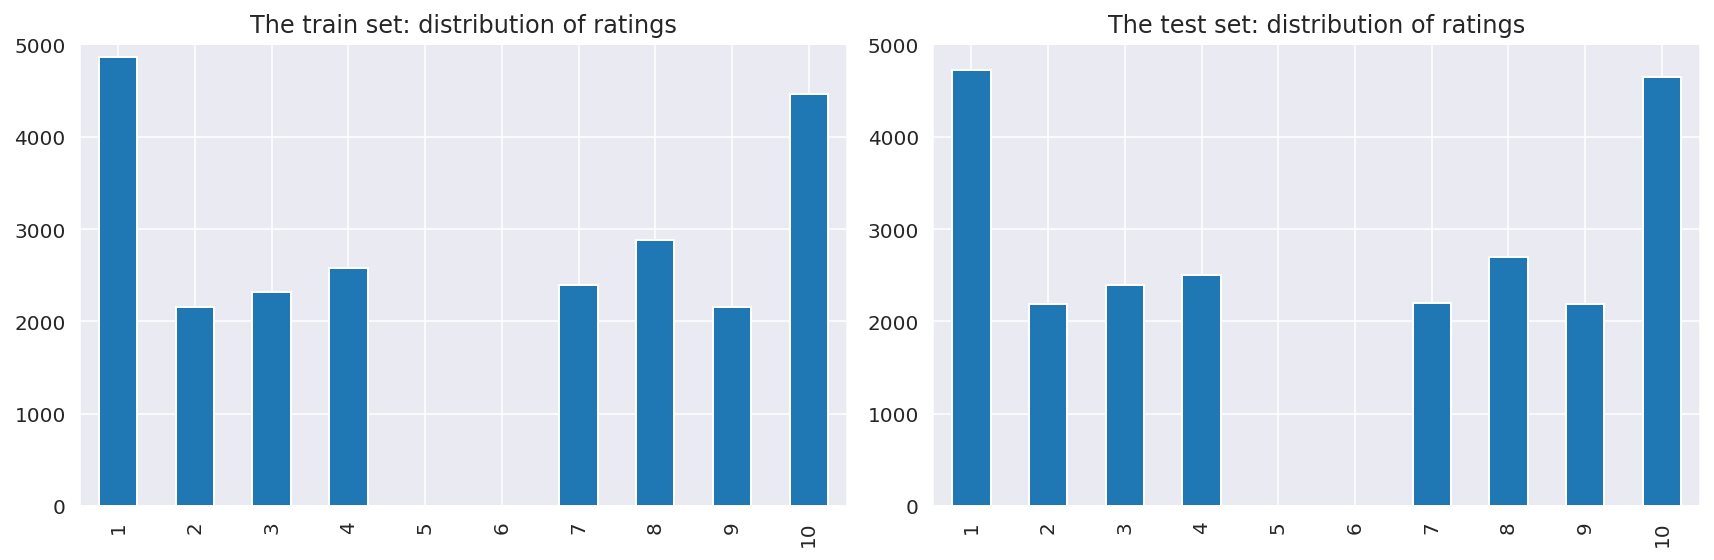

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


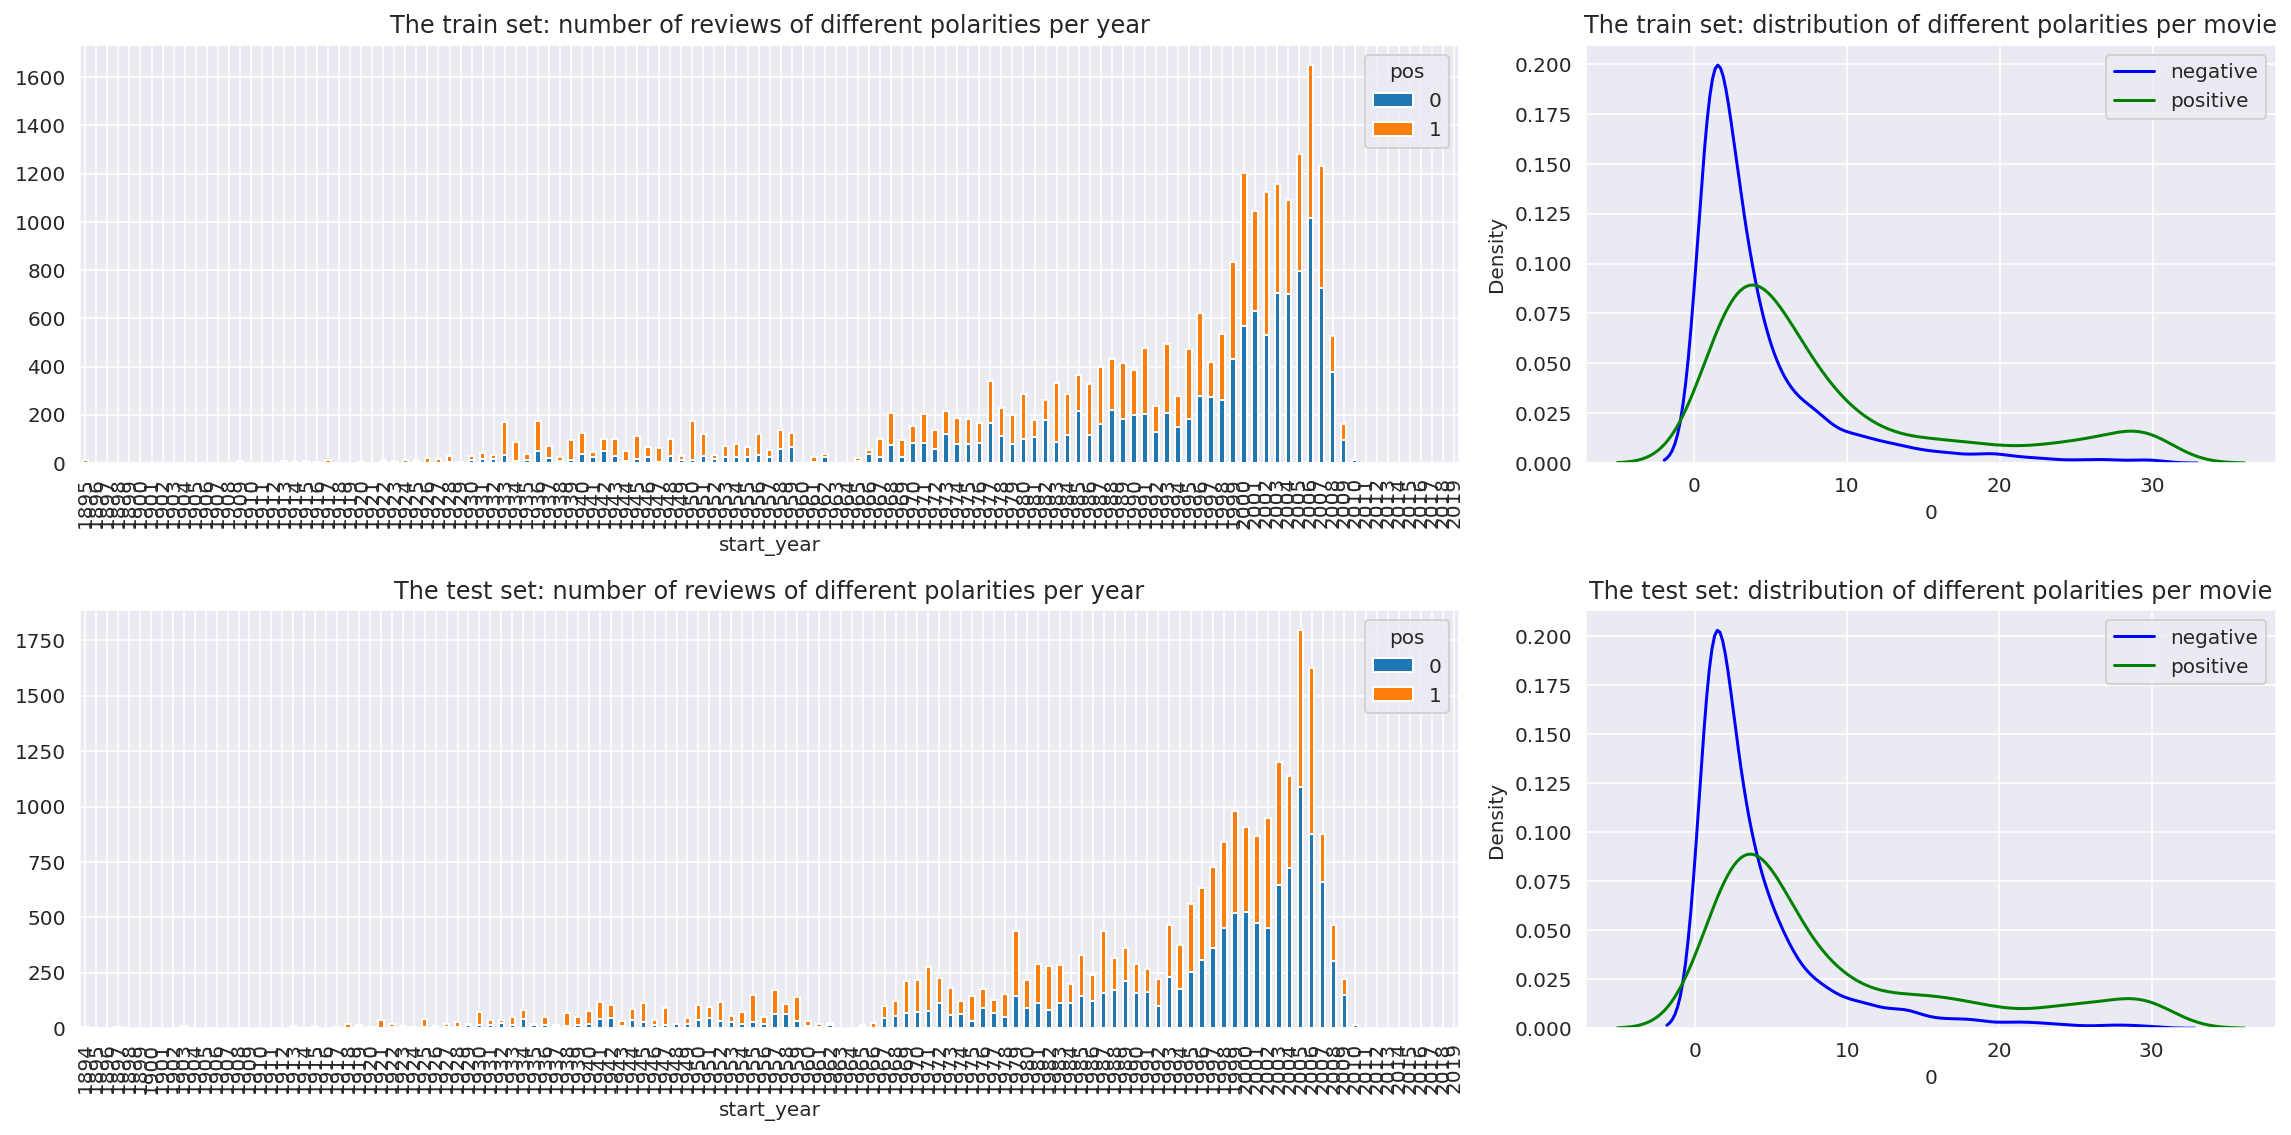

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Would be nice to add some comments to the plots in the EDA. Did you find out anything interesting?
    
</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [18]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        color = 'blue' if type == 'train' else 'green'
        
        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [19]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: " ".join(re.sub(r"[^A-Za-z]", " ", x.lower()).split()))


In [20]:
df_reviews.loc[99, 'review']


'In 1996\'s "101 Dalmatians," Cruella De Vil was arrested by the London Metropolitain Police (God bless them) for attempting to steal and murder 101 puppies - dalmatians. All covered in mud and hay, she spent the next 4 years in the "tin can." Now, 4 years later, she, unfortunately, was released from the jail. I say, that\'s about 28 years - in dog years!!!!! So, in 2000, Disney decided to release a sequel to the successful live-action version of the classic film and it is hereby dubbed "102 Dalmatians." In it, there is a 102nd dalmatian added to the family (Oddball is the name, I think; I should know this since this was just shown on TV recently), and the puppy had no spots!!!!! Also, while Cruella (again played by Glenn Close) has escaped again, she wanted a bigger, better coat - made once again out of the puppies!!!!! I especially liked the theme song - I\'m sure everybody loves the "Atomic Dog" song from the 70s or so. And now, we hear a bit of it in this movie!!!!! "102 Dalmatians

In [21]:
df_reviews.loc[99, 'review_norm']

'in s dalmatians cruella de vil was arrested by the london metropolitain police god bless them for attempting to steal and murder puppies dalmatians all covered in mud and hay she spent the next years in the tin can now years later she unfortunately was released from the jail i say that s about years in dog years so in disney decided to release a sequel to the successful live action version of the classic film and it is hereby dubbed dalmatians in it there is a nd dalmatian added to the family oddball is the name i think i should know this since this was just shown on tv recently and the puppy had no spots also while cruella again played by glenn close has escaped again she wanted a bigger better coat made once again out of the puppies i especially liked the theme song i m sure everybody loves the atomic dog song from the s or so and now we hear a bit of it in this movie dalmatians is such a great film that i keep on wondering when will there be a dalmatians lol stars'

<div class="alert alert-success">
<b>Reviewer's comment</b>

Normalization looks good!
    
    
</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [23]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

model_0 = DummyClassifier(strategy='stratified', random_state=random_state)

In [24]:
%%time
model_0.fit(train_features, train_target)

CPU times: user 2.39 ms, sys: 325 µs, total: 2.72 ms
Wall time: 30.4 ms


DummyClassifier(random_state=42, strategy='stratified')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


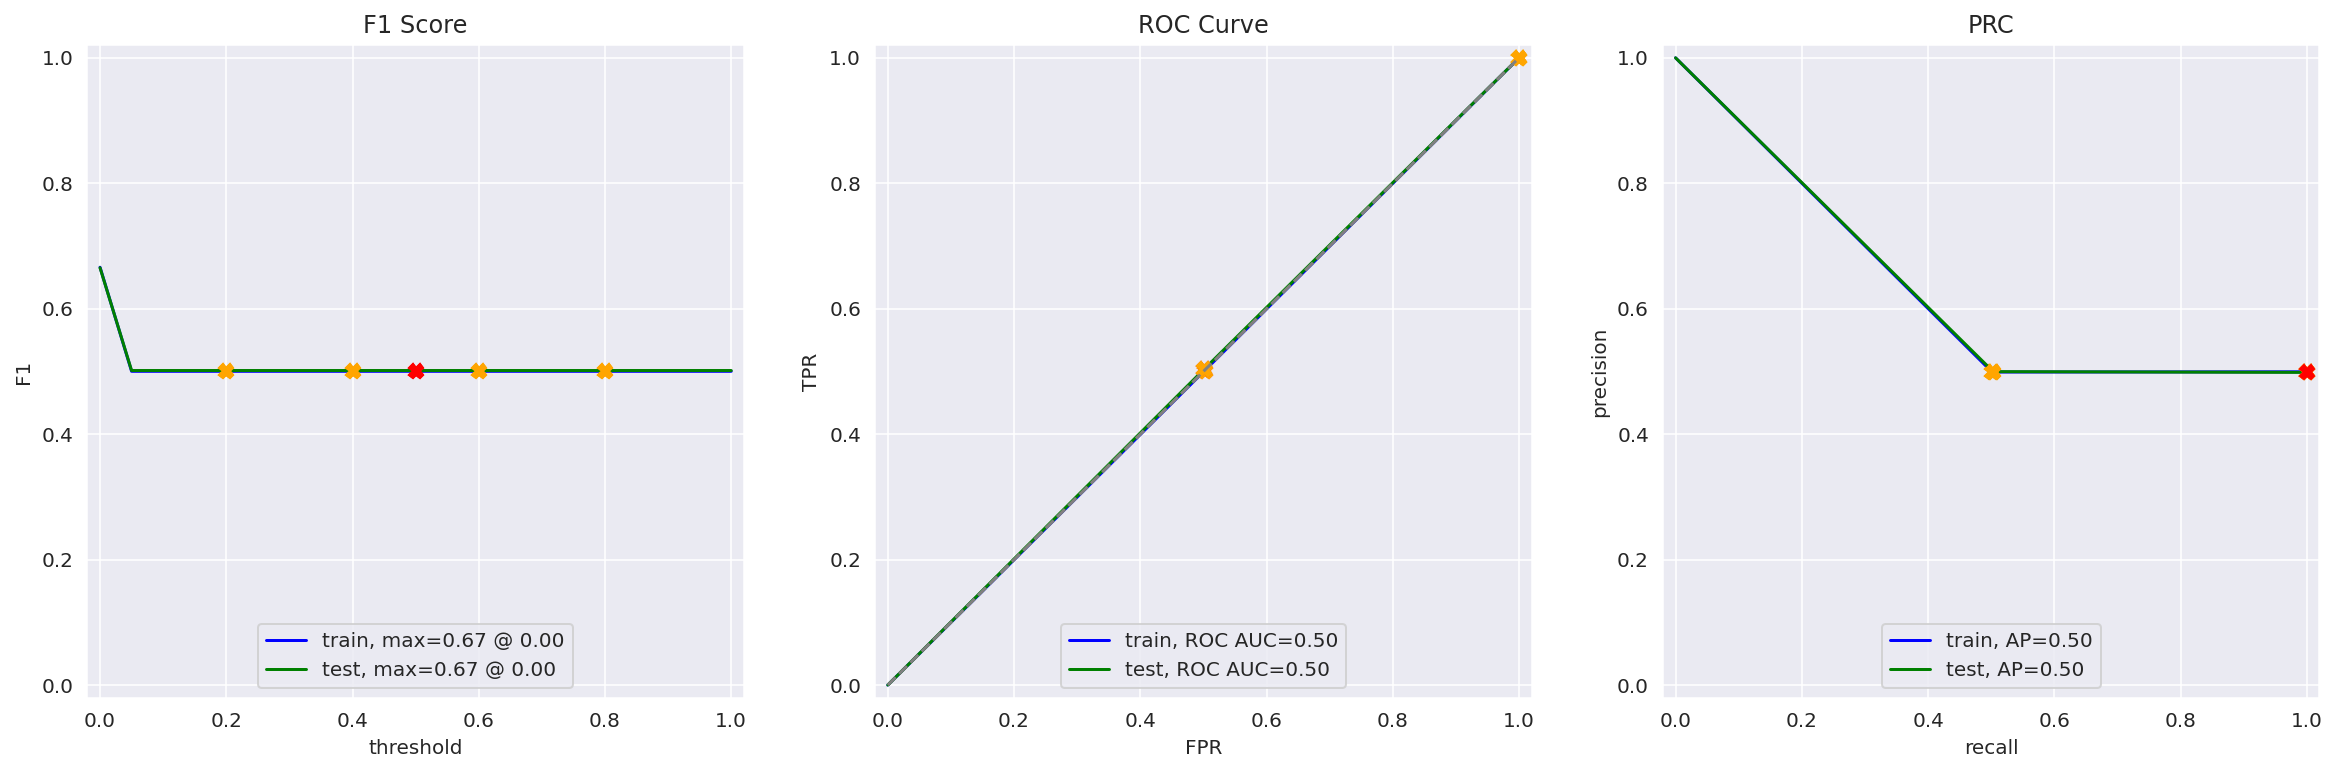

In [25]:
evaluate_model(model_0, train_features, train_target, test_features, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, there's a simple baseline!
    
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [26]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(str_input):
    words_tokenized = word_tokenize(str_input)
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words_tokenized]
    
    return " ".join(words_lemmatized)

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_reviews_train['review_norm_lemmatized'] = df_reviews_train['review_norm'].progress_apply(preprocess_text)
df_reviews_test['review_norm_lemmatized'] = df_reviews_test['review_norm'].progress_apply(preprocess_text)

train_features = df_reviews_train['review_norm_lemmatized']
test_features = df_reviews_test['review_norm_lemmatized']

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [ ]:
stop_words = list(stopwords.words('english'))

model_1 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(max_iter=300, random_state=random_state))]
)
model_1.fit(train_features, train_target)

In [ ]:
params = {
    'lr__C': [0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(model_1, params, scoring='f1', cv=3, n_jobs=-1, verbose=1)

grid_1.fit(train_features, train_target)

print(f'Best Parameters: {grid_1.best_params_}')
print(f'Best F1 Score: {grid_1.best_score_}')

In [ ]:
model_1 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(random_state=random_state))]
)
model_1.fit(train_features, train_target)

In [ ]:
evaluate_model(model_1, train_features, train_target, test_features, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [ ]:
train_features_3 = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
test_features_3 = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

In [ ]:
model_3 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(max_iter=300, random_state=random_state))]
)
model_3.fit(train_features_3, train_target)

params = {
    'lr__C': [0.1, 1, 10, 100]
}

grid_3 = GridSearchCV(model_3, params, scoring='f1', cv=3, n_jobs=-1, verbose=1)

grid_3.fit(train_features, train_target)

print(f'Best Parameters: {grid_3.best_params_}')
print(f'Best F1 Score: {grid_3.best_score_}')

In [ ]:
model_3 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LogisticRegression(random_state=random_state))]
)
model_3.fit(train_features_3, train_target)

In [ ]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
model_4 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lgbm', LGBMClassifier(force_row_wise=True, random_state=random_state, verbose=0))]
)

params = {
    'lgbm__learning_rate': [0.01, 0.1, 0.2, 1],
    'lgbm__n_estimators': [100, 200, 300],
    'lgbm__num_leaves': [16, 32, 64] 
}

grid_4 = GridSearchCV(model_4, params, scoring='f1', cv=3, n_jobs=-1, verbose=1)

grid_4.fit(train_features_3, train_target)

print(f'Best Parameters: {grid_4.best_params_}')
print(f'Best F1 Score: {grid_4.best_score_}')

In [ ]:
model_4 = Pipeline(
    steps=[('tfidf', TfidfVectorizer(stop_words=stop_words)),
           ('lr', LGBMClassifier(learning_rate=0.2, num_leaves=9, n_estimators=300, random_state=random_state))]
)
model_4.fit(train_features_3, train_target)

In [ ]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you succesfully used TF-IDF to vectorize text data and trained a couple of different models using the resulting features. It's nice that you used pipelines and tuned hyperparameters with a cross-validated grid search. Good idea to try lemmatization!
    
</div>

###  Model 9 - BERT

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    for input_text in texts:
        encoded = tokenizer.encode_plus(input_text, max_length=max_length, pad_to_max_length=True, return_tensors='pt')
        ids_list.append(encoded['input_ids'])
        attention_mask_list.append(encoded['attention_mask'])
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        start_idx = batch_size * i
        end_idx = min(batch_size * (i+1), len(ids_list))
            
        ids_batch = torch.stack(ids_list[start_idx:end_idx]).to(device)
        attention_mask_batch = torch.stack(attention_mask_list[start_idx:end_idx]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch.squeeze(), attention_mask=attention_mask_batch.squeeze())   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The code for generating BERT embeddings is correct
    
</div>

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(
    df_reviews_train['review_norm'][:2500],
    force_device='cuda'
)

test_features_9 = BERT_text_to_embeddings(
    df_reviews_test['review_norm'][:1000],
    force_device='cuda'
)

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
evaluate_model(model_9, X_train, y_train, X_test, y_test)

<div class="alert alert-success">
<b>Reviewer's comment</b>

If you'd like to try running BERT on the whole dataset, check out google colab or kaggle notebooks, both platform offer a VM with a GPU for free with some limitations.
    
</div>

## My Reviews

In [ ]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = # <put here the same normalization logic as for the main dataset>

my_reviews

### Model 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were applied to new reviews correctly
    
</div>

## Conclusions

I wanted to submit something to get some feedback before I go back to see what else I need to fix. 

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

All looks good, just add a final conclusion :)
    
</div>

After the initilization and setting up the enviorment, loading teh data with initial inspecition, EDA with distributing the movies and reviews over the year for negative and positive review to provide charts and graphs. 
Evaluating procedures with metrics such as accuracy, F1 score, ROC AUC, and average precision score to help set up the training and test set. 
I then normalize the process by using NLTK for tokenization lemmatization and TF-IDF vectorization since it is essential for text based models. 
Then I split the set of data to run baseline model DummyClassifier, NLTK, TF-IDF, and Logistic Regression with the use of GridSearchCV for hyperparameter to tune the model.

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

Conclusions look good, although it seems that they were cut off a bit, in the future I suggest clicking 'Save and checkpoint' when you finish working on a jupyter notebook to avoid losing data.
    
The project is accepted. Keep up the good work on the next sprint!

</div>

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions